# Behaviour Cloning Project

>In this project, I am describing the behaviour cloning of Self Driving Car in Udacity

In [1]:
import cv2
from keras.models import Sequential
from keras import layers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.backend.tensorflow_backend import set_session
from keras.optimizers import rmsprop
from keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import set_random_seed

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
# dynamically grow the memory used on the GPU
config.log_device_placement = True
# to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)


Using TensorFlow backend.


Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



Setting seed value of 1

In [2]:
SEED = 1
np.random.seed(SEED)
set_random_seed(SEED)

## Utility functions 

In [3]:
def read_images(batch):
    images = [None]*len(batch)
    for i,image_name in enumerate(batch):
        image = cv2.imread(image_name)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images[i] = image
    images = np.array(images)
    return images
    

generater of loading data

In [4]:
def loader(data,batch_size):
    i = 0
    while True:
        batch = data.iloc[i:i+batch_size]
        batch_image_names = batch["Center Image"].values.tolist()
        batch_images = read_images(batch_image_names)
        steering = batch["Steering"].values.tolist()
        i = i+batch_size
        if i>= len(data):
            i = 0
        yield batch_images,steering
            

### Data folder

In [5]:
DATA_FOLDER = "../data/Simulator/"
normal = os.path.join(DATA_FOLDER,"CenterLaneDriving")
recovery = os.path.join(DATA_FOLDER,"RecoveryLap")
recovery2 = os.path.join(DATA_FOLDER,"RecoveryLap2")
difficult = os.path.join(DATA_FOLDER,"Difficult")
difficult2 = os.path.join(DATA_FOLDER,"Difficult2")
difficult_recovery = os.path.join(DATA_FOLDER,"DifficultRecovery")

Names of the collumns

In [6]:
names = ["Center Image","Left Image","Right Image","Steering", "Throttle", "Brake", "Speed"]

### Driving logs

In [7]:
normal_driving_log = pd.read_csv(os.path.join(normal,"driving_log.csv"),names = names)

In [8]:
normal_driving_log.head()

,Center Image,Left Image,Right Image,Steering,Throttle,Brake,Speed
0,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.892318
1,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.811010
2,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.750371
3,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.000000,0,9.670085
4,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.128493,0,9.627087


Steering angle distribution

<AxesSubplot:>

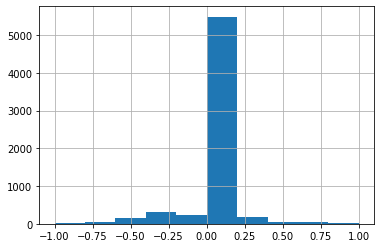

In [9]:
normal_driving_log["Steering"].hist(bins=10)

#### Recovery driving log

In [10]:
recovery_driving_log = pd.read_csv(os.path.join(recovery,"driving_log.csv"),names = names)
recovery_driving_log2 = pd.read_csv(os.path.join(recovery2,"driving_log.csv"),names = names)

In [11]:
recovery_driving_log.head()

,Center Image,Left Image,Right Image,Steering,Throttle,Brake,Speed
0,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,3.034396
1,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,3.011356
2,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.988503
3,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.971483
4,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,/home/sezan/Desktop/work/SelfDrivingCarND/data...,0.0,0.0,0.0,2.948949


Recovery driving log distribution

<AxesSubplot:>

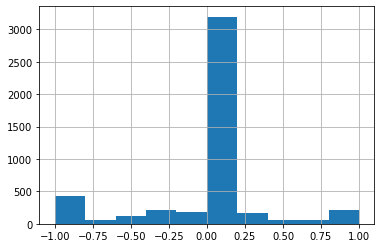

In [12]:
recovery_driving_log['Steering'].hist()

In the Recovery driving, we don't need the normal steering angle. The main purpose is to get the recovery driving which should not have steering angle of 0

<AxesSubplot:>

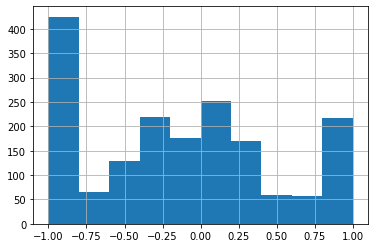

In [13]:
recovery_driving_log[recovery_driving_log["Steering"]!=0.0]["Steering"].hist()

also for the second recovery driving log

<AxesSubplot:>

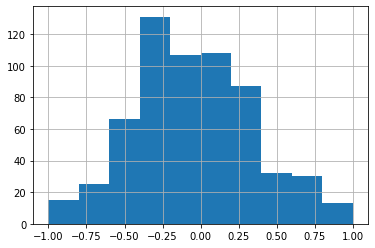

In [14]:
recovery_driving_log2[recovery_driving_log2["Steering"]!=0.0]["Steering"].hist()

In [15]:
recovery_driving_log = recovery_driving_log[recovery_driving_log["Steering"]!=0.0]
recovery_driving_log2 = recovery_driving_log2[recovery_driving_log2["Steering"]!=0.0]

### Normal Track

In [16]:
full_driving_log = pd.concat([normal_driving_log,recovery_driving_log,recovery_driving_log2])

We need only the `Center Image` and `Steering angle`

In [17]:
data = full_driving_log[["Center Image","Steering"]]

<AxesSubplot:>

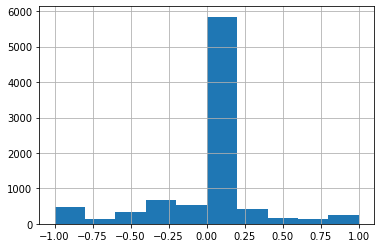

In [18]:
data["Steering"].hist()

Most of the steering angles are around `0`. This might bias our model . So I am removing those data

In [19]:
data = data[data["Steering"]!=0.0]

In [20]:
print("Number of data points: {}".format(len(data)))

Number of data points: 3674


In [21]:
data.head()

,Center Image,Steering
10,/home/sezan/Desktop/work/SelfDrivingCarND/data...,-0.05
11,/home/sezan/Desktop/work/SelfDrivingCarND/data...,-0.20
12,/home/sezan/Desktop/work/SelfDrivingCarND/data...,-0.40
13,/home/sezan/Desktop/work/SelfDrivingCarND/data...,-0.60
14,/home/sezan/Desktop/work/SelfDrivingCarND/data...,-0.75


array([[<AxesSubplot:title={'center':'Steering'}>]], dtype=object)

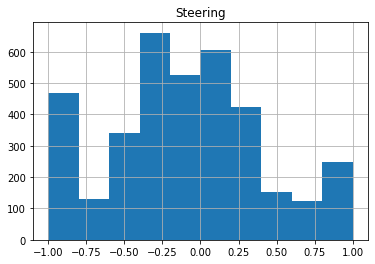

In [22]:
data.hist()

### Model training and Validation

Train test split

In [23]:
train,test =train_test_split(data)

<AxesSubplot:>

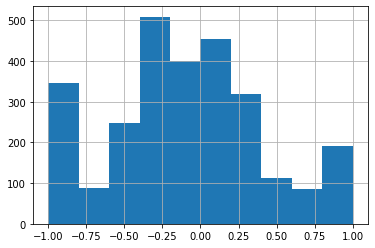

In [24]:
train["Steering"].hist()

<AxesSubplot:>

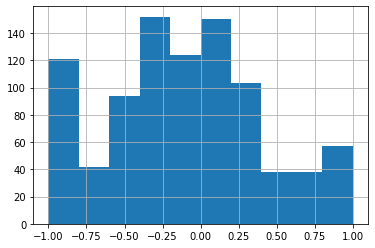

In [25]:
test["Steering"].hist()

function for reading images

### Model

After many iterations I have selected a sequential model based on `Alexnet`. The problem looked simple enough to use this model

In [26]:
model = Sequential()
model.add(layers.Lambda(lambda x: x / 255.0, input_shape=(160, 320, 3)))
model.add(layers.Cropping2D(cropping=((50, 20), (0, 0))))
model.add(
    layers.Conv2D(
        64, (5, 5), strides=(1, 1), activation="relu", kernel_regularizer=l2(0.01)
    )
)
model.add(layers.Dropout(0.5))
model.add(layers.MaxPooling2D(pool_size=2, strides=2))
model.add(layers.Conv2D(128, (5, 5), activation="relu", kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(256, (5, 5), activation="relu", kernel_regularizer=l2(0.01)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(units=250, activation="relu", kernel_regularizer=l2(0.01)))
model.add(layers.Dense(units=120, activation="relu", kernel_regularizer=l2(0.01)))
model.add(layers.Dense(units=84, activation="relu", kernel_regularizer=l2(0.01)))
model.add(layers.Dense(1))
model.compile(optimizer=rmsprop(lr=0.0001, rho=0.9), loss="mse")
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 86, 316, 64)       4864      
_________________________________________________________________
dropout_1 (Dropout)          (None, 86, 316, 64)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 43, 158, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 39, 154, 128)      204928    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 19, 77, 128)       0         
_____

In [27]:
train_loader = loader(train,32)
test_loader = loader(test,32)

In [28]:
history = model.fit_generator(train_loader,steps_per_epoch=len(train)//32,validation_data=test_loader,validation_steps=87,epochs=50,
                              callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                                        ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')])



Epoch 1/50




86/86 [==============================] - 15s 175ms/step - loss: 6.9824 - val_loss: 4.7383
Epoch 2/50
86/86 [==============================] - 12s 135ms/step - loss: 3.7482 - val_loss: 3.0232
Epoch 3/50
86/86 [==============================] - 11s 133ms/step - loss: 2.5926 - val_loss: 2.2950
Epoch 4/50
86/86 [==============================] - 11s 133ms/step - loss: 2.0320 - val_loss: 1.8623
Epoch 5/50
86/86 [==============================] - 12s 134ms/step - loss: 1.6645 - val_loss: 1.5578
Epoch 6/50
86/86 [==============================] - 11s 132ms/step - loss: 1.3796 - val_loss: 1.3028
Epoch 7/50
86/86 [==============================] - 11s 133ms/step - loss: 1.1471 - val_loss: 1.0973
Epoch 8/50
86/86 [==============================] - 11s 134ms/step - loss: 0.9610 - val_loss: 0.9303
Epoch 9/50
86/86 [==============================] - 11s 132ms/step - loss: 0.8091 - val_loss: 0.7911
Epoch 10/50
86/86 [==============================] - 11s 132ms/step - loss: 0.6867 - 

Let's look at the loss curve

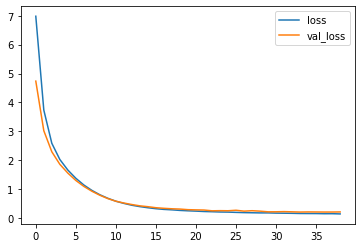

In [29]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()


Perfect!

## Difficult track

The another track of the simulator is very difficult. I also collected data from that track

In [30]:
difficult_driving_log =  pd.read_csv(os.path.join(difficult,"driving_log.csv"),names = names)

<AxesSubplot:>

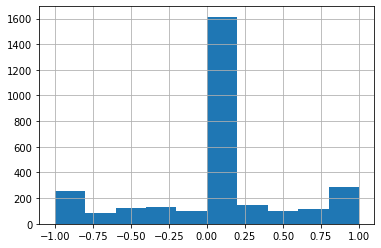

In [31]:
difficult_driving_log["Steering"].hist()

In [32]:
difficult_driving_log2 = pd.read_csv(os.path.join(difficult2,"driving_log.csv"),names = names)

<AxesSubplot:>

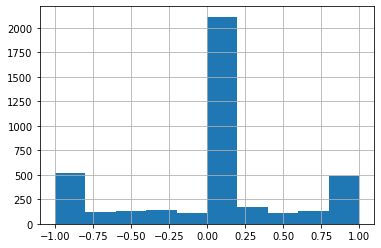

In [33]:
difficult_driving_log2["Steering"].hist()

In [34]:
difficult_recovery = pd.read_csv(os.path.join(difficult_recovery,"driving_log.csv"),names = names)

In [35]:
full_difficult_driving_log = pd.concat([difficult_driving_log,difficult_driving_log2,difficult_recovery])

In [36]:
data = full_difficult_driving_log[["Center Image","Steering"]]

<AxesSubplot:>

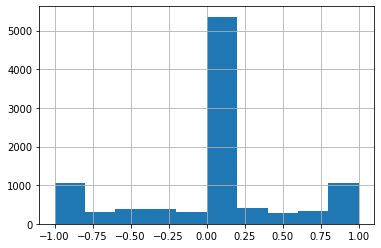

In [37]:
data["Steering"].hist()

Again we see that the values around 0 is too high. So again , I have excluded those values

In [38]:
data = data[data["Steering"]!=0.0]

array([[<AxesSubplot:title={'center':'Steering'}>]], dtype=object)

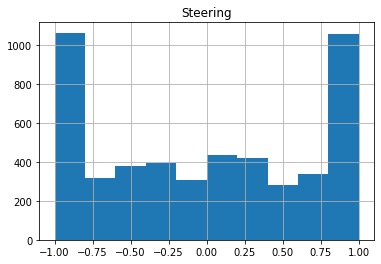

In [39]:
data.hist()

So, let's train again!

In [40]:
print("Number of data points: {}".format(len(data)))

Number of data points: 4987


In [41]:
train,test =train_test_split(data)

### Model

In [42]:
model_difficult = Sequential()
model_difficult.add(layers.Lambda(lambda x: x / 255.0, input_shape=(160, 320, 3)))
model_difficult.add(layers.Cropping2D(cropping=((50, 20), (0, 0))))
model_difficult.add(
    layers.Conv2D(
        64, (5, 5), strides=(1, 1), activation="relu", kernel_regularizer=l2(0.01)
    )
)
model_difficult.add(layers.Dropout(0.5))
model_difficult.add(layers.MaxPooling2D(pool_size=2, strides=2))
model_difficult.add(layers.Conv2D(128, (5, 5), activation="relu", kernel_regularizer=l2(0.01)))
model_difficult.add(layers.MaxPooling2D((2, 2)))
model_difficult.add(layers.Conv2D(256, (5, 5), activation="relu", kernel_regularizer=l2(0.01)))
model_difficult.add(layers.MaxPooling2D((2, 2)))
model_difficult.add(layers.Dropout(0.5))
model_difficult.add(layers.Flatten())
model_difficult.add(layers.Dense(units=250, activation="relu", kernel_regularizer=l2(0.01)))
model_difficult.add(layers.Dense(units=120, activation="relu", kernel_regularizer=l2(0.01)))
model_difficult.add(layers.Dense(units=84, activation="relu", kernel_regularizer=l2(0.01)))
model_difficult.add(layers.Dense(1))
model_difficult.compile(optimizer=rmsprop(lr=0.0001, rho=0.9), loss="mse")
model_difficult.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 90, 320, 3)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 86, 316, 64)       4864      
_________________________________________________________________
dropout_3 (Dropout)          (None, 86, 316, 64)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 43, 158, 64)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 39, 154, 128)      204928    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 19, 77, 128)       0         
__________

In [43]:
train_loader = loader(train,32)
test_loader = loader(test,32)

In [44]:
history = model_difficult.fit_generator(train_loader,steps_per_epoch=len(train)//32,validation_data=test_loader,validation_steps=87,epochs=50,
                              callbacks=[EarlyStopping(monitor='val_loss',patience=5),
                                        ModelCheckpoint('model_difficult.h5', save_best_only=True, monitor='val_loss', mode='min')])

Epoch 1/50
116/116 [==============================] - 16s 141ms/step - loss: 6.3238 - val_loss: 4.0849
Epoch 2/50
116/116 [==============================] - 16s 142ms/step - loss: 3.1603 - val_loss: 2.6681
Epoch 3/50
116/116 [==============================] - 15s 131ms/step - loss: 2.2443 - val_loss: 2.0508
Epoch 4/50
116/116 [==============================] - 15s 130ms/step - loss: 1.7501 - val_loss: 1.6506
Epoch 5/50
116/116 [==============================] - 15s 130ms/step - loss: 1.4019 - val_loss: 1.3641
Epoch 6/50
116/116 [==============================] - 15s 132ms/step - loss: 1.1379 - val_loss: 1.1143
Epoch 7/50
116/116 [==============================] - 15s 130ms/step - loss: 0.9340 - val_loss: 1.0073
Epoch 8/50
116/116 [==============================] - 15s 131ms/step - loss: 0.7803 - val_loss: 0.8091
Epoch 9/50
116/116 [==============================] - 15s 132ms/step - loss: 0.6614 - val_loss: 0.6766
Epoch 10/50
116/116 [==============================] - 15s 132ms/step - l

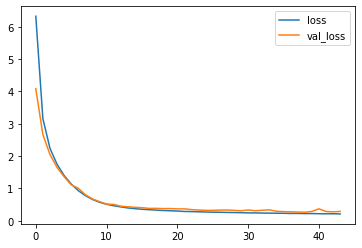

In [45]:
plt.plot(history.history['loss'],label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.legend()